# NAME: SINGH ARJITA
# PROJECT: BRAIN TUMOR CLASSIFICATION

## MACHINE LEARNING METHOD

In [2]:
import cv2
import numpy as np
from tqdm import tqdm
from tensorflow import keras
from skimage.feature import hog
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, recall_score, classification_report, f1_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import skimage as ski
import os
import glob
from sklearn.linear_model import LogisticRegression
import zipfile
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import csv,os,re,sys,codecs
import joblib,  statistics
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
import warnings
from imblearn.under_sampling import RandomUnderSampler

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
zip_file_path ='/content/drive/MyDrive/archive (1).zip'

extracted_folder_path = 'extracted'

os.makedirs(extracted_folder_path, exist_ok=True)

################################################################################################################################################################################
# EXTRACTING THE CONTENTS OF THE ZIP FILE INTO ANOTHER DIRECTORY
################################################################################################################################################################################
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

print(f'Files extracted to: {extracted_folder_path}')

Files extracted to: extracted


In [5]:
################################################################################################################################################################################
# CREATING TRAINING DATASET FROM THE GIVEN FOLDER DIRECTORY
################################################################################################################################################################################
training=keras.utils.image_dataset_from_directory(
    directory='extracted/Training',
    labels='inferred',
    label_mode='int',
    batch_size=10,
    image_size=(128,128)
)

################################################################################################################################################################################
# CREATING VALIDATION DATASET FROM THE GIVEN FOLDER DIRECTORY
################################################################################################################################################################################
validation=keras.utils.image_dataset_from_directory(
    directory='extracted/Testing',
    labels='inferred',
    label_mode='int',
    batch_size=10,
    image_size=(128,128)
)

Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


In [6]:
################################################################################################################################################################################
# TRAINING
################################################################################################################################################################################
x_train_list = []
y_train_list = []

################################################################################################################################################################################
# EXTRACTING THE IMAGES AND THEIR LABELS
################################################################################################################################################################################
for x_batch, y_batch in training:
    x_train_list.append(x_batch.numpy())
    y_train_list.append(y_batch.numpy())

################################################################################################################################################################################
# CONCATENATING FOR THE INDIVIDUAL BATCHES
################################################################################################################################################################################
x_train = np.concatenate(x_train_list, axis=0)
y_train = np.concatenate(y_train_list, axis=0)

In [7]:
################################################################################################################################################################################
# VALIDATION (SIMILARILY)
################################################################################################################################################################################
x_val_list = []
y_val_list = []

for x_batch, y_batch in validation:
    x_val_list.append(x_batch.numpy())
    y_val_list.append(y_batch.numpy())

x_val = np.concatenate(x_val_list, axis=0)
y_val = np.concatenate(y_val_list, axis=0)

In [8]:
################################################################################################################################################################################
# HISTOGRAM OF ORIENTEDGRADIENTS (HOG) FEATURE EXTRACTION ON A LIST OF INPUT IMAGES
################################################################################################################################################################################
def preprocess_hog(images):
    hog_imgs = []
    # Using tqdm module to run the codes faster
    for x in tqdm(images):
        gray_image = cv2.cvtColor(x, cv2.COLOR_RGB2GRAY) / 255
        feature_descriptor = hog(gray_image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2))
        hog_imgs.append(feature_descriptor)
    return np.array(hog_imgs)

In [9]:
################################################################################################################################################################################
# RESHAPING TO A FLAT 1D ARRAY
################################################################################################################################################################################
y_train = y_train.reshape(-1)
y_val = y_val.reshape(-1)

################################################################################################################################################################################
# HOG FEATURES
################################################################################################################################################################################
x_train = preprocess_hog(x_train)
x_val = preprocess_hog(x_val)

100%|██████████| 1311/1311 [00:11<00:00, 115.07it/s]


In [ ]:
################################################################################################################################################################################
# AFTER RESHAPING
################################################################################################################################################################################
y_train.shape

(5712,)

In [ ]:
training.class_names

['glioma', 'meningioma', 'notumor', 'pituitary']

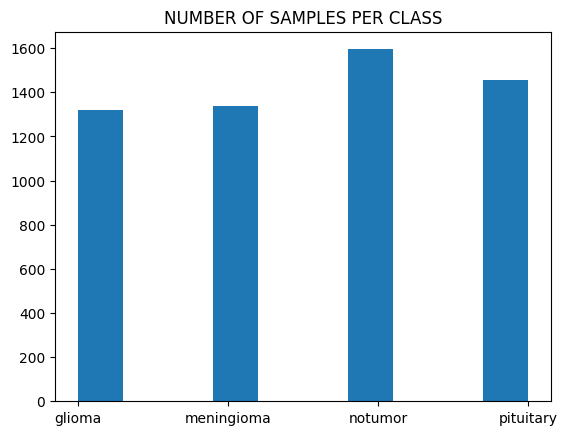

In [ ]:
################################################################################################################################################################################
# PLOTTING A HISTOGRAM OF SAMPLES WITHIN A CLASS
################################################################################################################################################################################
y_train_eda=pd.DataFrame(y_train)
plt.hist(y_train_eda)
plt.title("NUMBER OF SAMPLES PER CLASS")
plt.xticks([0, 1, 2, 3], ['glioma', 'meningioma', 'notumor', 'pituitary'])
plt.show()

In [10]:
undersampler = RandomUnderSampler(sampling_strategy='majority', random_state=42)

################################################################################################################################################################################
# RESAMPLING THE DATA (UNDERSAMPLING)
################################################################################################################################################################################
X_resampled, y_resampled = undersampler.fit_resample(x_train, y_train)

print("Class distribution after undersampling:", np.bincount(y_resampled))

for i in range(2):
  undersampler = RandomUnderSampler(sampling_strategy='majority', random_state=42)
  X_resampled, y_resampled = undersampler.fit_resample(X_resampled, y_resampled)
  print("Class distribution after undersampling:", np.bincount(y_resampled))

Class distribution after undersampling: [1321 1339 1321 1457]
Class distribution after undersampling: [1321 1339 1321 1321]
Class distribution after undersampling: [1321 1321 1321 1321]


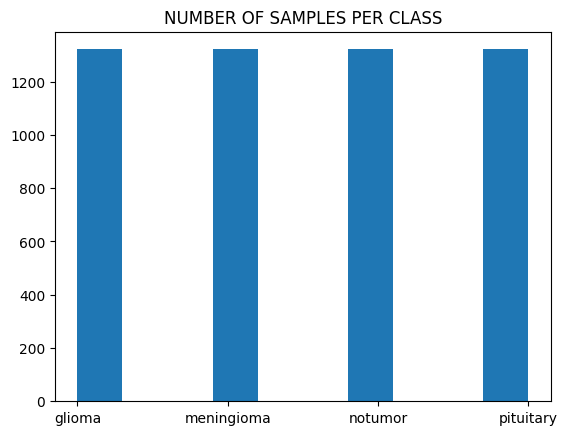

In [ ]:
################################################################################################################################################################################
# PLOTTING A HISTOGRAM OF SAMPLES WITHIN A CLASS AFTER RESAMPLING
################################################################################################################################################################################
y_train_eda=pd.DataFrame(y_resampled)
plt.hist(y_train_eda)
plt.title("NUMBER OF SAMPLES PER CLASS")
plt.xticks([0, 1, 2, 3], ['glioma', 'meningioma', 'notumor', 'pituitary'])
plt.show()

In [11]:
################################################################################################################################################################################
# FUNCTION TO EVALUATE PERFORMANCE OF MODELS
################################################################################################################################################################################
def evaluation(y_val,y_pred):
  confusion_mat = confusion_matrix(y_val, y_pred)
  accuracy=accuracy_score(y_val, y_pred)
  precision = precision_score(y_val, y_pred, average='macro')
  recall = recall_score(y_val, y_pred, average='macro')

  print("The accuracy is:")
  print(accuracy)
  print("The precision is: ")
  print(precision)
  print("The recall is:")
  print(recall)
  print("The confusion matrix is: ")
  f,ax=plt.subplots(figsize=(5,5))
  sns.heatmap(confusion_mat,annot=True,fmt=".0f")
  ax.set_xticklabels(['glioma', 'meningioma', 'notumor', 'pituitary'])
  ax.set_yticklabels(['glioma', 'meningioma', 'notumor', 'pituitary'])
  plt.show()

### STANDARD SCALER + PCA + SVM

Evaluating on Training
The accuracy is:
1.0
The precision is: 
1.0
The recall is:
1.0
The confusion matrix is: 


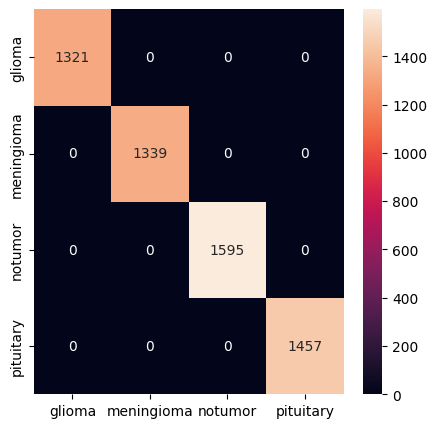

Evaluating on Validation
The accuracy is:
0.969488939740656
The precision is: 
0.9676189552908212
The recall is:
0.9670098039215687
The confusion matrix is: 


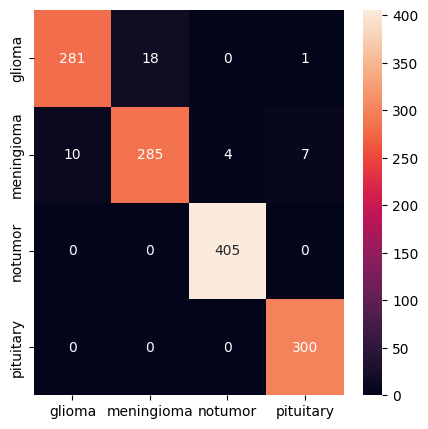

In [12]:
################################################################################################################################################################################
# SVM + PCA(85%) + STANDARD SCALER
################################################################################################################################################################################
pipe = Pipeline([('standardscaler', StandardScaler()), ('pca', PCA(.85)), ('svm', SVC(kernel='rbf', C=10, cache_size=10000, random_state=40))])
pipe.fit(x_train, y_train)
y_pred = pipe.predict(x_val)
y_train_pred=pipe.predict(x_train)

print("Evaluating on Training")
evaluation(y_train, y_train_pred)

print("Evaluating on Validation")
evaluation(y_val,y_pred)

Evaluating on Training
The accuracy is:
1.0
The precision is: 
1.0
The recall is:
1.0
The confusion matrix is: 


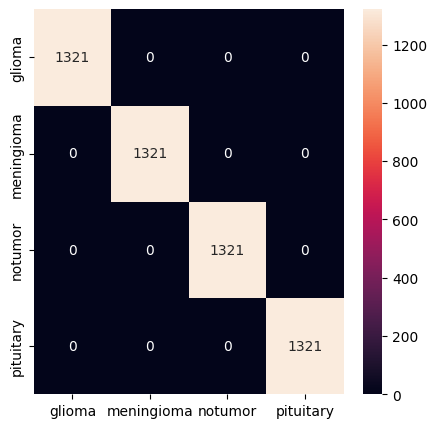

Evaluating on Validation
The accuracy is:
0.9679633867276888
The precision is: 
0.9660413808362134
The recall is:
0.9655591866376181
The confusion matrix is: 


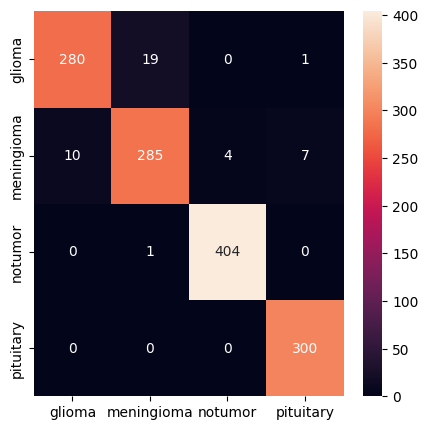

In [13]:
################################################################################################################################################################################
# USING UNDERSAMPLED DATA
################################################################################################################################################################################
pipe = Pipeline([('standardscaler', StandardScaler()), ('pca', PCA(.85)), ('svm', SVC(kernel='rbf', C=10, cache_size=10000, random_state=40))])
pipe.fit(X_resampled, y_resampled)
y_pred = pipe.predict(x_val)
y_train_pred=pipe.predict(X_resampled)

print("Evaluating on Training")
evaluation(y_resampled, y_train_pred)

print("Evaluating on Validation")
evaluation(y_val,y_pred)

Evaluating on Training
The accuracy is:
1.0
The precision is: 
1.0
The recall is:
1.0
The confusion matrix is: 


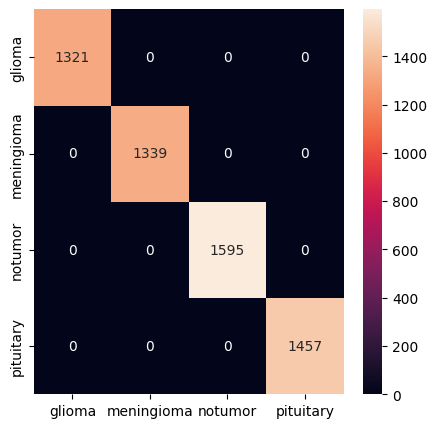

Evaluating on Validation
The accuracy is:
0.9801678108314263
The precision is: 
0.979239797701279
The recall is:
0.978578431372549
The confusion matrix is: 


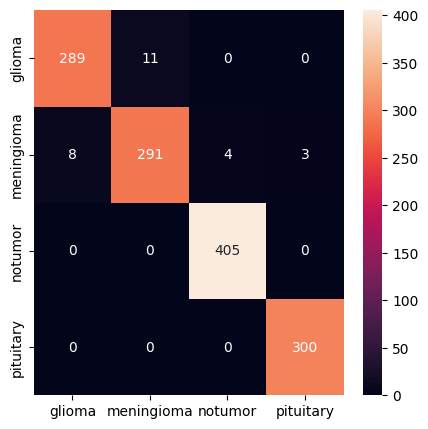

In [14]:
################################################################################################################################################################################
#  SVM + PCA(60%) + STANDARD SCALER
################################################################################################################################################################################
pipe = Pipeline([('standardscaler', StandardScaler()), ('pca', PCA(.60)), ('svm', SVC(kernel='rbf', C=10, cache_size=10000, random_state=40))])
pipe.fit(x_train, y_train)
y_pred = pipe.predict(x_val)
y_train_pred=pipe.predict(x_train)

print("Evaluating on Training")
evaluation(y_train, y_train_pred)

print("Evaluating on Validation")
evaluation(y_val,y_pred)

Evaluating on Training
The accuracy is:
1.0
The precision is: 
1.0
The recall is:
1.0
The confusion matrix is: 


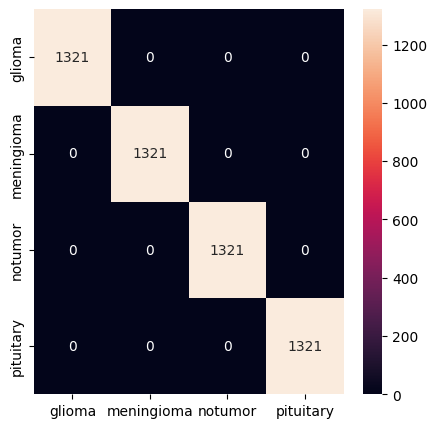

Evaluating on Validation
The accuracy is:
0.9763539282990084
The precision is: 
0.9751691425806693
The recall is:
0.9746441539578795
The confusion matrix is: 


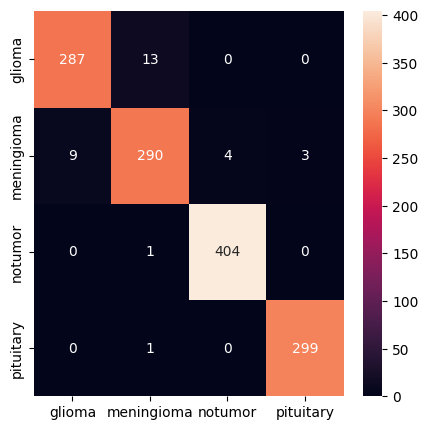

In [15]:
################################################################################################################################################################################
# USING UNDERSAMPLED DATA
################################################################################################################################################################################
pipe = Pipeline([('standardscaler', StandardScaler()), ('pca', PCA(.60)), ('svm', SVC(kernel='rbf', C=10, cache_size=10000, random_state=40))])
pipe.fit(X_resampled, y_resampled)
y_pred = pipe.predict(x_val)
y_train_pred=pipe.predict(X_resampled)

print("Evaluating on Training")
evaluation(y_resampled, y_train_pred)

print("Evaluating on Validation")
evaluation(y_val,y_pred)

Evaluating on Training
The accuracy is:
0.9992997198879552
The precision is: 
0.9992513219442749
The recall is:
0.9992632069175567
The confusion matrix is: 


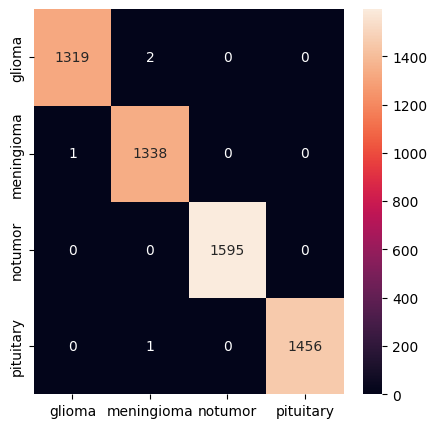

Evaluating on Validation
The accuracy is:
0.9809305873379099
The precision is: 
0.9797575510761243
The recall is:
0.9793627450980392
The confusion matrix is: 


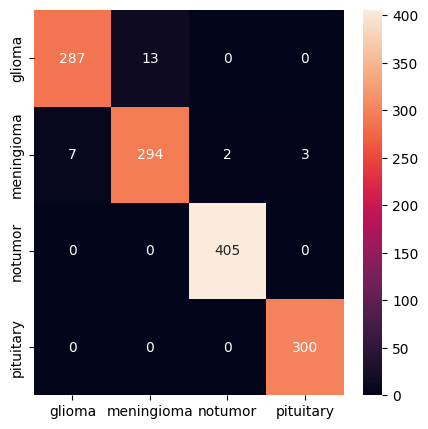

In [16]:
################################################################################################################################################################################
#  SVM + PCA(50%) + STANDARD SCALER
################################################################################################################################################################################
pipe = Pipeline([('standardscaler', StandardScaler()), ('pca', PCA(.50)), ('svm', SVC(kernel='rbf', C=10, cache_size=10000, random_state=40))])
pipe.fit(x_train, y_train)
y_pred_fin = pipe.predict(x_val)
y_train_pred=pipe.predict(x_train)

print("Evaluating on Training")
evaluation(y_train, y_train_pred)

print("Evaluating on Validation")
evaluation(y_val,y_pred_fin)

Evaluating on Training
The accuracy is:
0.9992429977289932
The precision is: 
0.9992437126365697
The recall is:
0.9992429977289932
The confusion matrix is: 


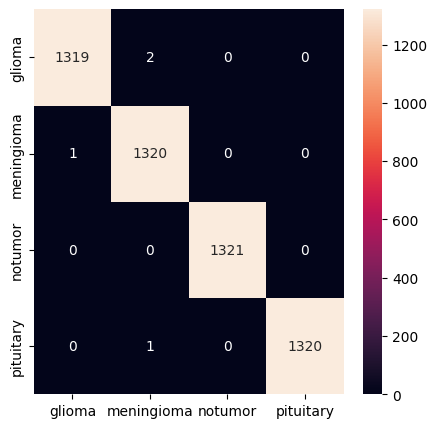

Evaluating on Validation
The accuracy is:
0.9786422578184591
The precision is: 
0.9771933645758988
The recall is:
0.9771278140885984
The confusion matrix is: 


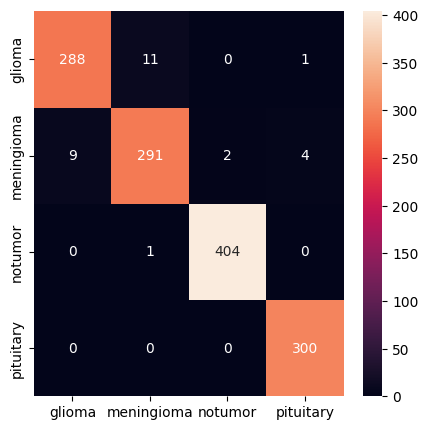

In [17]:
################################################################################################################################################################################
# USING UNDERSAMPLED DATA
################################################################################################################################################################################
pipe = Pipeline([('standardscaler', StandardScaler()), ('pca', PCA(.50)), ('svm', SVC(kernel='rbf', C=10, cache_size=10000, random_state=40))])
pipe.fit(X_resampled, y_resampled)
y_pred = pipe.predict(x_val)
y_train_pred=pipe.predict(X_resampled)

print("Evaluating on Training")
evaluation(y_resampled, y_train_pred)

print("Evaluating on Validation")
evaluation(y_val,y_pred)

Evaluating on Training
The accuracy is:
0.9954481792717087
The precision is: 
0.9952871852854694
The recall is:
0.9952283063593059
The confusion matrix is: 


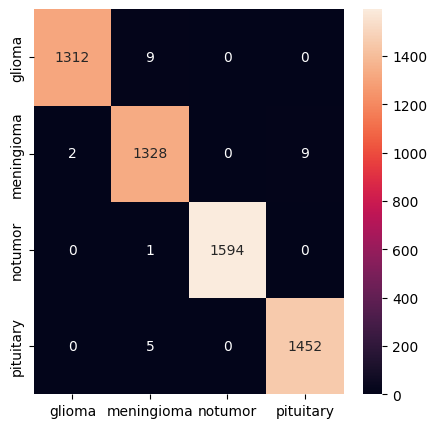

Evaluating on Validation
The accuracy is:
0.9725400457665904
The precision is: 
0.9705946792289567
The recall is:
0.970526506899056
The confusion matrix is: 


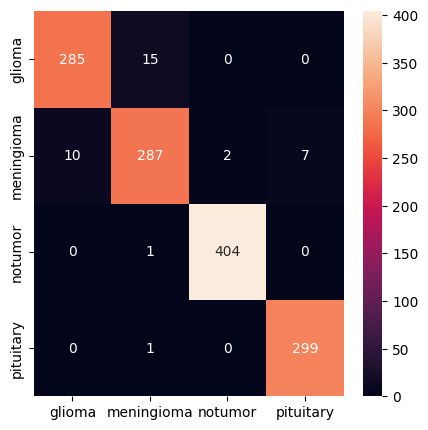

In [18]:
################################################################################################################################################################################
#  SVM + PCA(45%) + STANDARD SCALER
################################################################################################################################################################################
pipe = Pipeline([('standardscaler', StandardScaler()), ('pca', PCA(.45)), ('svm', SVC(kernel='rbf', C=10, cache_size=10000, random_state=40))])
pipe.fit(x_train, y_train)
y_pred = pipe.predict(x_val)
y_train_pred=pipe.predict(x_train)

print("Evaluating on Training")
evaluation(y_train, y_train_pred)

print("Evaluating on Validation")
evaluation(y_val,y_pred)

Evaluating on Training
The accuracy is:
0.9952687358062074
The precision is: 
0.9952836824123495
The recall is:
0.9952687358062074
The confusion matrix is: 


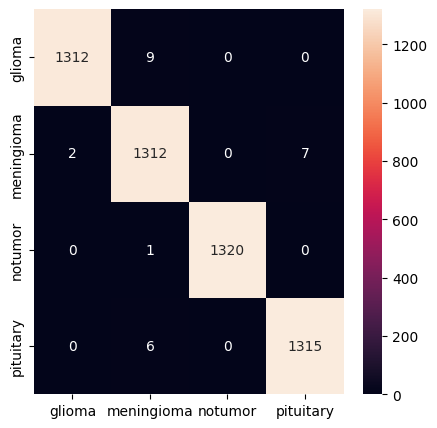

Evaluating on Validation
The accuracy is:
0.9672006102212052
The precision is: 
0.9648939135966441
The recall is:
0.9649419026870006
The confusion matrix is: 


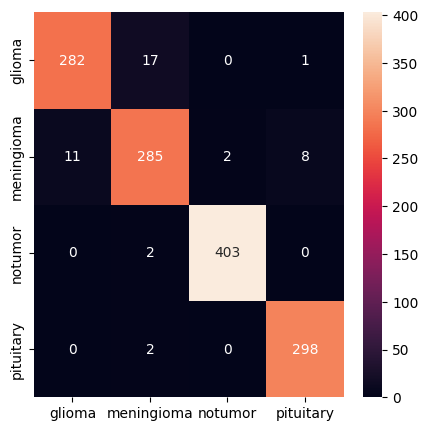

In [19]:
################################################################################################################################################################################
# USING UNDERSAMPLED DATA
################################################################################################################################################################################
pipe = Pipeline([('standardscaler', StandardScaler()), ('pca', PCA(.45)), ('svm', SVC(kernel='rbf', C=10, cache_size=10000, random_state=40))])
pipe.fit(X_resampled, y_resampled)
y_pred = pipe.predict(x_val)
y_train_pred=pipe.predict(X_resampled)

print("Evaluating on Training")
evaluation(y_resampled, y_train_pred)

print("Evaluating on Validation")
evaluation(y_val,y_pred)

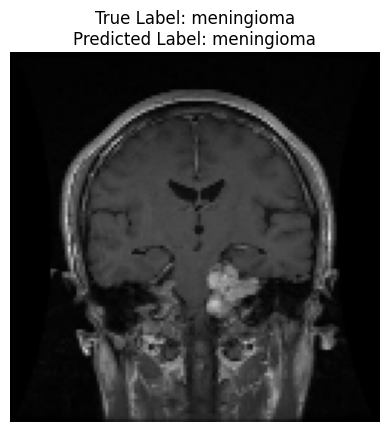

In [28]:
################################################################################################################################################################################
# CONVERTING THE NUMERIC LABELS TO THE ACTUAL CLASS LABEL
################################################################################################################################################################################
def no_to_label(number):
    labels = ['glioma', 'meningioma', 'notumor', 'pituitary']
    label = labels[number]
    return label

################################################################################################################################################################################
# PLOTTING A RANDOM IMAGE FROM THE VALIDATION AND DISLAYING ITS TRUE AND PREDICTED LABEL
################################################################################################################################################################################
validation_list = list(validation.unbatch()) #since the images are spread across batches
dataset_length = len(validation_list)
labels=[]
for image, label in validation_list:
  labels.append(label)

random_index = np.random.randint(0, dataset_length)
random_image, random_label = validation_list[random_index]

true_label_number=labels[random_index]
true_label_number = random_label.numpy()
true_label = no_to_label(true_label_number)

y_pred_flat = [pred.item() for pred in y_pred_fin]

predicted_label_number = y_pred_flat[random_index]
predicted_label = no_to_label(predicted_label_number)

plt.imshow(random_image.numpy().astype("uint8"))
plt.title(f"True Label: {true_label}\nPredicted Label: {predicted_label}")
plt.axis('off')
plt.show()

### GRID SEARCH


In [ ]:
################################################################################################################################################################################
# DEFINING STRATIFIED K FOLD
################################################################################################################################################################################
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

################################################################################################################################################################################
# STANDAR SCALING
################################################################################################################################################################################
scaler=StandardScaler()
x_train_scaled=scaler.fit_transform(x_train)
x_val_scaled=scaler.transform(x_val)

warnings.filterwarnings("ignore")

################################################################################################################################################################################
# MIN MAX SCALING
################################################################################################################################################################################
scaler=MinMaxScaler()
x_train_scaled2=scaler.fit_transform(x_train)
x_val_scaled2=scaler.transform(x_val)

Best Hyperparameters:  DecisionTreeClassifier(ccp_alpha=0.01, criterion='entropy', max_depth=10,
                       max_features='sqrt', random_state=42)
Best Accuracy:  0.7102591036414566
The accuracy is:
0.669717772692601
The precision is: 
0.6601010438048251
The recall is:
0.6617193173565723
The confusion matrix is: 


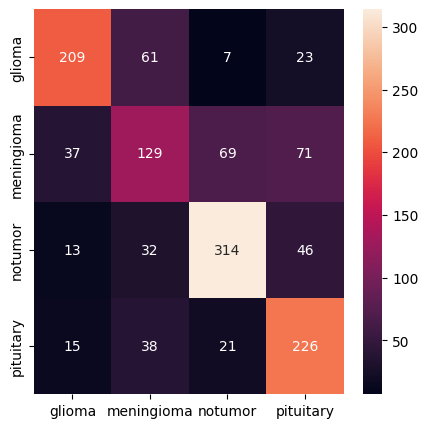

In [ ]:
################################################################################################################################################################################
# DECISION TREE
################################################################################################################################################################################
param_grid = {
            'criterion':('gini', 'entropy'),
            'max_features':('sqrt', 'log2'),
            'max_depth':(10,20,30),
            'ccp_alpha':(0.01, 0.1),
            }

decision_tree = DecisionTreeClassifier(random_state=42)

grid = GridSearchCV(estimator=decision_tree, param_grid=param_grid, scoring='accuracy', cv=stratified_kfold)
grid_search = grid.fit(x_train_scaled, y_train)
print("Best Hyperparameters: ", grid_search.best_estimator_ )
print("Best Accuracy: ", grid_search.best_score_)

y_pred_dt=grid_search.best_estimator_.predict(x_val_scaled)
evaluation(y_val,y_pred_dt)

Best Hyperparameters:  {'algorithm': 'auto', 'n_neighbors': 1, 'weights': 'uniform'}
Best Accuracy:  0.9483543417366946
The accuracy is:
0.6514111365369947
The precision is: 
0.6847392427558046
The recall is:
0.6394190268700073
The confusion matrix is: 


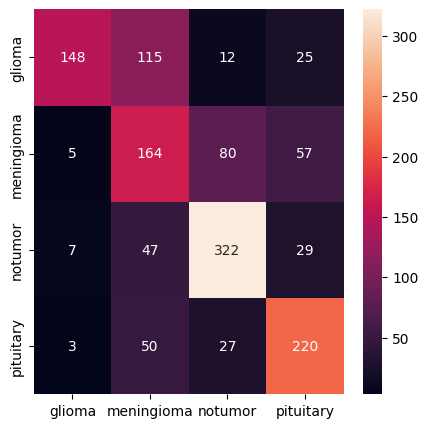

In [ ]:
################################################################################################################################################################################
# K-NEAREST NEIGHBOUR
################################################################################################################################################################################
param_grid = {
    'n_neighbors': [1, 3, 5],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

knn = KNeighborsClassifier()

grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, scoring='accuracy', cv=stratified_kfold)
grid_search.fit(x_train_scaled, y_train)

print("Best Hyperparameters: ", grid_search.best_estimator_ )
print("Best Accuracy: ", grid_search.best_score_)

y_pred_knn=grid_search.best_estimator_.predict(x_val_scaled)
evaluation(y_val,y_pred_knn)

Best Hyperparameters:  SVC(C=100, random_state=42)
Best Accuracy:  0.9397759103641455
The accuracy is:
0.9641495041952708
The precision is: 
0.9628264496512444
The recall is:
0.9611111111111111
The confusion matrix is: 


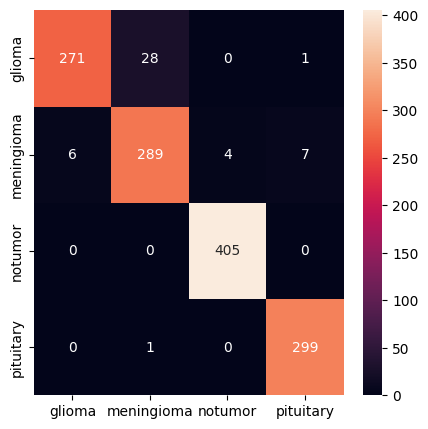

In [ ]:
################################################################################################################################################################################
# SUPPORT VECTOR MACHINE
################################################################################################################################################################################
param_grid = {
    'C': [0.1, 1, 100],
    'kernel': ['linear', 'rbf']
}

svm = SVC(random_state=42)

grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, scoring='accuracy', cv=3)
grid_search.fit(x_train_scaled, y_train)

print("Best Hyperparameters: ", grid_search.best_estimator_ )
print("Best Accuracy: ", grid_search.best_score_)

y_pred_svm=grid_search.best_estimator_.predict(x_val_scaled)
evaluation(y_val,y_pred_svm)

Best Hyperparameters:  LogisticRegression(C=1, random_state=42)
Best Accuracy:  0.9231442577030812
The accuracy is:
0.9321128909229596
The precision is: 
0.9283807865402813
The recall is:
0.9268700072621641
The confusion matrix is: 


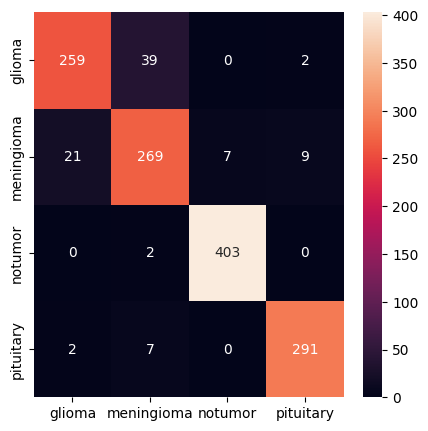

In [ ]:
################################################################################################################################################################################
# LOGISTIC REGRESSION
################################################################################################################################################################################

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']
}

logistic_reg = LogisticRegression(random_state=42)

grid_search = GridSearchCV(estimator=logistic_reg, param_grid=param_grid, scoring='accuracy', cv=stratified_kfold)
grid_search.fit(x_train_scaled, y_train)

print("Best Hyperparameters: ", grid_search.best_estimator_ )
print("Best Accuracy: ", grid_search.best_score_)

y_pred_lr=grid_search.best_estimator_.predict(x_val_scaled)
evaluation(y_val,y_pred_lr)

Best Hyperparameters:  RandomForestClassifier(max_depth=100, n_estimators=80, random_state=42)
Best Accuracy:  0.8879551820728291
The accuracy is:
0.9046529366895499
The precision is: 
0.9001998956242211
The recall is:
0.8965686274509803
The confusion matrix is: 


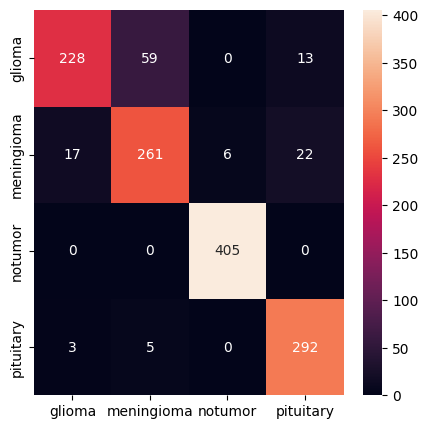

In [ ]:
################################################################################################################################################################################
# RANDOM FOREST
################################################################################################################################################################################

param_grid = {
            'criterion':('entropy','gini'),
            'n_estimators':(40,80),
            'max_depth':(15,45,100),
            }

random_forest = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=random_forest, param_grid=param_grid, scoring='accuracy', cv=stratified_kfold)
grid_search.fit(x_train_scaled, y_train)

print("Best Hyperparameters: ", grid_search.best_estimator_ )
print("Best Accuracy: ", grid_search.best_score_)

y_pred_rf=grid_search.best_estimator_.predict(x_val_scaled)
evaluation(y_val,y_pred_rf)

Best Hyperparameters:  MultinomialNB(alpha=0)
Best Accuracy:  0.7162114845938375
The accuracy is:
0.6399694889397407
The precision is: 
0.6235774088038291
The recall is:
0.6265904139433551
The confusion matrix is: 


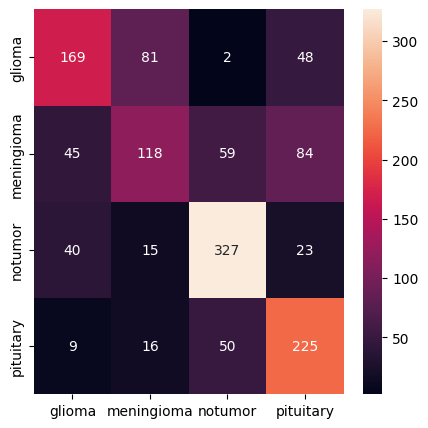

In [ ]:
################################################################################################################################################################################
# MULTINOMIAL NAIVE BAYES
################################################################################################################################################################################

multinomial_naive_bayes = MultinomialNB(fit_prior=True, class_prior=None)
param_grid={
            'alpha':(0,1),
            }

grid_search = GridSearchCV(estimator=multinomial_naive_bayes, param_grid=param_grid, scoring='accuracy', cv=stratified_kfold)
grid_search.fit(x_train_scaled2, y_train)

print("Best Hyperparameters: ", grid_search.best_estimator_ )
print("Best Accuracy: ", grid_search.best_score_)

y_pred_rf=grid_search.best_estimator_.predict(x_val_scaled2)
evaluation(y_val,y_pred_rf)

## CONVOLUTIONAL NEURAL NETWORK

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.callbacks import ModelCheckpoint
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import array_to_img

In [ ]:
################################################################################################################################################################################
# STANDARDIZING AND NORMALIZING OF IMAGES
################################################################################################################################################################################
def preprocess_images(image, label):
    image = tf.image.resize(image, (128, 128))
    image = image / 255.0
    return image, label

################################################################################################################################################################################
training = training.map(preprocess_images)
validation = validation.map(preprocess_images)

In [ ]:
################################################################################################################################################################################
# DEFINING A CNN USING KERAS SEQUENTIAL MODEL
################################################################################################################################################################################
model = Sequential([
    Conv2D(32, (3, 3), activation = 'relu', input_shape = (128, 128, 3)), #1st layer, 32 3x3 filter
    MaxPooling2D(2, 2), #To reduce the spatial dimension of the image

    Conv2D(64, (3, 3), activation = 'relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation = 'relu'),
    MaxPooling2D(2, 2),

    Flatten(),

    Dense(512, activation = "relu"),
    Dense(4, activation = "softmax") #SINCE 4 CLASS CLASSIFICATION
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 128)       0

In [ ]:
print(len(training), len(validation))

572 132


In [ ]:
for batch in training.take(5):  # INSPECTION
    images, labels = batch
    print(images.shape, labels.shape)

(10, 128, 128, 3) (10,)
(10, 128, 128, 3) (10,)
(10, 128, 128, 3) (10,)
(10, 128, 128, 3) (10,)
(10, 128, 128, 3) (10,)


In [ ]:
y_train_cnn = np.concatenate([y for x, y in training], axis=0)

y_val_cnn = np.concatenate([y for x, y in validation], axis=0)

from tensorflow.keras.utils import to_categorical

num_classes = 4  # Replace with the actual number of classes in your dataset

# One-hot encode the labels
y_train_one_hot = to_categorical(y_train_cnn, num_classes=4)
y_val_one_hot = to_categorical(y_val_cnn, num_classes=4)

In [ ]:
################################################################################################################################################################################
# COMPILING
################################################################################################################################################################################
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'], run_eagerly=True)

################################################################################################################################################################################
# MODEL TRAINING
################################################################################################################################################################################
history = model.fit(training,
                    #steps_per_epoch = len(training),
                    epochs = 10,
                    validation_data = validation,
                    #validation_steps = len(validation),
                    )

Epoch 1/10
572/572 [==============================] - 539s 937ms/step - loss: 0.5303 - accuracy: 0.7936 - val_loss: 0.3838 - val_accuracy: 0.8421
Epoch 2/10
572/572 [==============================] - 494s 863ms/step - loss: 0.2304 - accuracy: 0.9147 - val_loss: 0.3009 - val_accuracy: 0.8818
Epoch 3/10
572/572 [==============================] - 497s 869ms/step - loss: 0.1378 - accuracy: 0.9489 - val_loss: 0.2175 - val_accuracy: 0.9138
Epoch 4/10
572/572 [==============================] - 486s 850ms/step - loss: 0.1102 - accuracy: 0.9601 - val_loss: 0.1937 - val_accuracy: 0.9275
Epoch 5/10
572/572 [==============================] - 486s 849ms/step - loss: 0.0591 - accuracy: 0.9814 - val_loss: 0.1891 - val_accuracy: 0.9519
Epoch 6/10
572/572 [==============================] - 482s 842ms/step - loss: 0.0424 - accuracy: 0.9853 - val_loss: 0.2980 - val_accuracy: 0.9298
Epoch 7/10
572/572 [==============================] - 491s 858ms/step - loss: 0.0622 - accuracy: 0.9814 - val_loss: 0.1909 -

In [ ]:
################################################################################################################################################################################
# EVALUATING PERFORMANCE
################################################################################################################################################################################
val_loss, val_accuracy = model.evaluate(validation)

print(f'Test Accuracy: {val_accuracy * 100:.2f}%')
print(f'Test Loss: {val_loss:.4f}')

132/132 [==============================] - 20s 148ms/step - loss: 0.1705 - accuracy: 0.9542
Test Accuracy: 95.42%
Test Loss: 0.1705


In [ ]:
################################################################################################################################################################################
# PREDICTING VALIDATION
################################################################################################################################################################################
predictions = model.predict(validation)

132/132 [==============================] - 19s 138ms/step


In [ ]:
def no_to_label(number):
    labels = ['glioma', 'meningioma', 'notumor', 'pituitary']
    label = labels[number]
    return label

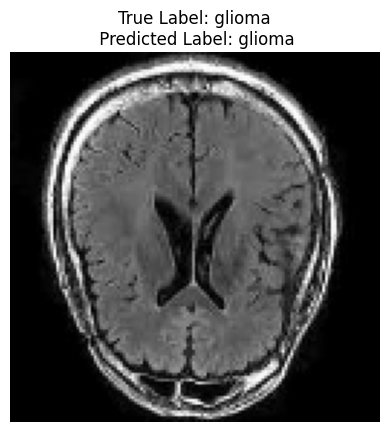

In [ ]:
################################################################################################################################################################################
# PLOTTING A RANDOM IMAGE FROM VALIDATION AND DISPLAYING THE TRUE LABEL AND PREDICTED LABEL
################################################################################################################################################################################
random_index = np.random.randint(len(validation))

# CHOOSING THE RANDOM SAMPLE
chosen_sample = validation.take(random_index + 1)


for images, true_labels in chosen_sample:
    random_image = images[0]
    random_label = true_labels[0]

    # PREDICTED LABEL OF THAT IMAGE
    predicted_label = np.argmax(predictions[random_index])
    predicted_label=no_to_label(predicted_label)

    true=np.argmax(random_label)
    truth=no_to_label(true)

    # CONVERTING NUMPY ARRAY TO PIL IMAGE
    pil_image = array_to_img(random_image.numpy())

    # DISPLAYING THE IMAGE
    plt.imshow(pil_image)
    plt.title(f'True Label: {truth}\n Predicted Label: {predicted_label}')
    plt.axis('off')
    plt.show()
    break